<a href="https://colab.research.google.com/github/Tuevu110405/Module5_1st_step_toDL/blob/feature%2FMLP/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --id 1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu
To: /content/Auto_MPG_data.csv
100% 15.4k/15.4k [00:00<00:00, 29.4MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [ ]:
dataset_path = '/content/Auto_MPG_data.csv'
dataset = pd.read_csv(dataset_path)

In [ ]:
X = dataset.drop(columns= 'MPG').values
y = dataset['MPG'].values

In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train , X_val, y_train, y_val = train_test_split(
    X,y,
    test_size = val_size,
    random_state = random_state,
    shuffle = is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size = test_size,
    random_state = random_state,
    shuffle = is_shuffle
)

In [ ]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims,hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [ ]:
input_dims = X_train.shape[1]
output_dims = 1
hidden_dims = 64

model = MLP(input_dims = input_dims, hidden_dims = hidden_dims, output_dims = output_dims)


In [ ]:
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

In [ ]:
def r_squared(y_true, y_pred):
    y_true = torch.Tensor(y_true).to(device)
    y_pred = torch.Tensor(y_pred).to(device)
    mean_true = torch.mean(y_true)
    ss_tot = torch.sum((y_true - mean_true)**2)
    ss_res = torch.sum((y_true - y_pred)**2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [ ]:
epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        train_predict += outputs.tolist()
        train_target += y_samples.tolist()
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_predict += outputs.tolist()
            val_target += y_samples.tolist()
            loss = criterion(outputs, y_samples)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r_squared(val_target, val_predict))
    print (f'\nEPOCH {epoch + 1}:\tTraining loss : {train_loss:.3f}\
    tValidation loss : {val_loss:.3f}')


EPOCH 1:	Training loss : 616.895    tValidation loss : 628.557

EPOCH 2:	Training loss : 611.790    tValidation loss : 628.557

EPOCH 3:	Training loss : 611.243    tValidation loss : 628.557

EPOCH 4:	Training loss : 618.360    tValidation loss : 628.557

EPOCH 5:	Training loss : 619.341    tValidation loss : 628.557

EPOCH 6:	Training loss : 623.272    tValidation loss : 628.557

EPOCH 7:	Training loss : 620.952    tValidation loss : 628.557

EPOCH 8:	Training loss : 623.496    tValidation loss : 628.557

EPOCH 9:	Training loss : 630.381    tValidation loss : 628.557

EPOCH 10:	Training loss : 609.586    tValidation loss : 628.557

EPOCH 11:	Training loss : 619.293    tValidation loss : 628.557

EPOCH 12:	Training loss : 611.675    tValidation loss : 628.557

EPOCH 13:	Training loss : 622.190    tValidation loss : 628.557

EPOCH 14:	Training loss : 611.942    tValidation loss : 628.557

EPOCH 15:	Training loss : 613.499    tValidation loss : 628.557

EPOCH 16:	Training loss : 617.212

In [ ]:
input_dims = X_train.shape[1]
output_dims = 1
hidden_dims = 64

model = MLP(input_dims = input_dims, hidden_dims = hidden_dims, output_dims = output_dims)

# Move the model to the device (GPU)
model.to(device)

MLP(
  (linear1): Linear(in_features=9, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
model.eval()
with torch.no_grad():
    X_test = X_test.to(device)
    y_hat = model(X_test)
    test_set_r2 = r_squared(y_hat, y_test)
    print('Evaluation on test set: ')
    print(f'R2: {test_set_r2}')

Evaluation on test set: 
R2: -308901.53125


In [ ]:
! gdown --id 1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V
To: /content/NonLinear_data.npy
100% 5.57k/5.57k [00:00<00:00, 12.3MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [ ]:
data_path = '/content/NonLinear_data.npy'
data = np.load(data_path, allow_pickle = True).item()
X, y = data['X'], data['labels']

print(X.shape, y.shape)

(300, 2) (300,)


In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train , X_val, y_train, y_val = train_test_split(
    X,y,
    test_size = val_size,
    random_state = random_state,
    shuffle = is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size = test_size,
    random_state = random_state,
    shuffle = is_shuffle)

In [ ]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.long)
y_val = torch.tensor(y_val, dtype = torch.long)
y_test = torch.tensor(y_test, dtype = torch.long)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims,hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [ ]:
input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 128

model = MLP(input_dims = input_dims, hidden_dims = hidden_dims, output_dims = output_dims)

# Move the model to the device (GPU)
model.to(device)

MLP(
  (linear1): Linear(in_features=2, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=3, bias=True)
)

In [ ]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

In [ ]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim = 1)
    accuracy = torch.sum(y_hat == y_true).item() / len(y_true)
    return accuracy

In [ ]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = [] # Initialize val_predict as an empty list for each epoch
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)

        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())


    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)
    model.eval()
    val_loss = 0.0
    val_predict = []
    val_target = []
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            # Append the outputs as tensors to val_predict
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())
            loss = criterion(outputs, y_samples)
            val_loss += loss.item()



    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Concatenate the tensors in val_predict and val_target
    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)
    print (f'\nEPOCH {epoch + 1}:\tTraining loss : {train_loss:.3f}\
    tValidation loss : {val_loss:.3f}')


EPOCH 1:	Training loss : 1.004    tValidation loss : 0.944

EPOCH 2:	Training loss : 0.849    tValidation loss : 0.876

EPOCH 3:	Training loss : 0.773    tValidation loss : 0.831

EPOCH 4:	Training loss : 0.726    tValidation loss : 0.810

EPOCH 5:	Training loss : 0.691    tValidation loss : 0.790

EPOCH 6:	Training loss : 0.678    tValidation loss : 0.765

EPOCH 7:	Training loss : 0.655    tValidation loss : 0.719

EPOCH 8:	Training loss : 0.623    tValidation loss : 0.738

EPOCH 9:	Training loss : 0.595    tValidation loss : 0.667

EPOCH 10:	Training loss : 0.581    tValidation loss : 0.673

EPOCH 11:	Training loss : 0.565    tValidation loss : 0.621

EPOCH 12:	Training loss : 0.542    tValidation loss : 0.622

EPOCH 13:	Training loss : 0.513    tValidation loss : 0.578

EPOCH 14:	Training loss : 0.498    tValidation loss : 0.597

EPOCH 15:	Training loss : 0.474    tValidation loss : 0.560

EPOCH 16:	Training loss : 0.474    tValidation loss : 0.493

EPOCH 17:	Training loss : 0.442 

Text(0.5, 1.0, 'Validation Accuracy')

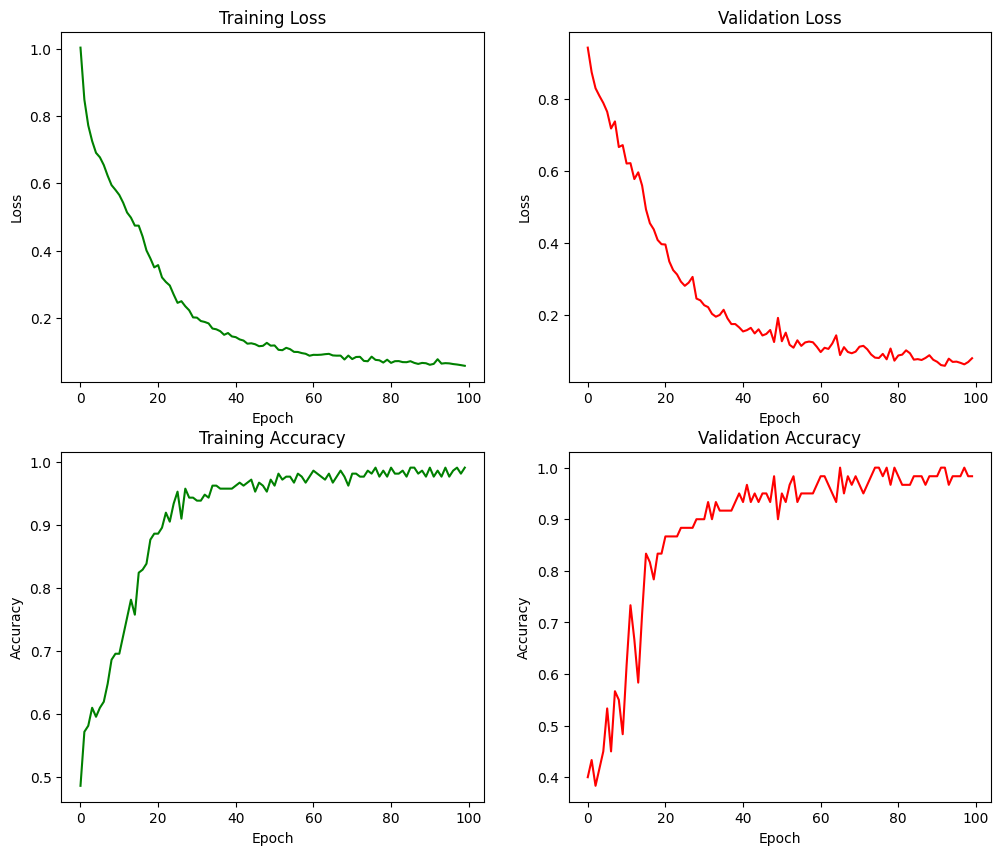

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (12,10))
ax[0, 0].plot(train_losses, color = 'green')
ax[0, 0].set(xlabel= 'Epoch', ylabel ='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color = 'red')
ax[0, 1].set(xlabel= 'Epoch', ylabel ='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color = 'green')
ax[1, 0].set(xlabel= 'Epoch', ylabel ='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color = 'red')
ax[1, 1].set(xlabel= 'Epoch', ylabel ='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

In [ ]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = compute_accuracy(test_predict, test_target)
print(f'Test Accuracy: {test_acc}')

Test Accuracy: 0.9333333333333333


In [ ]:
!gdown --id 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
From (redirected): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8&confirm=t&uuid=f3872559-4031-4c49-a057-9b37797be9a1
To: /content/FER-2013.zip
100% 63.3M/63.3M [00:01<00:00, 43.9MB/s]


In [ ]:
!unzip -q '/content/FER-2013.zip'

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize, Normalize # Import Normalize
from torchvision.io import read_image
from sklearn.model_selection import train_test_split


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'

classes = os.listdir(train_dir)

label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {idx:cls for cls, idx in label2idx.items()}

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image
from sklearn.model_selection import train_test_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)


train_dir = '/content/train'
test_dir = '/content/test'

classes = os.listdir(train_dir)

label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {idx:cls for cls, idx in label2idx.items()}

test_img_path = '/content/train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)
print(f'Image height : {img_height}\nImage width : {img_width}')

class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx,
                 split = 'train', train_ratio = 0.8):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.label2idx = label2idx
        self.img_dir = img_dir
        # Call read_img_files as a method
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size = train_ratio,
                random_state = random_state,
                stratify = self.img_labels
            )
            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)

    # Define read_img_files as a method of the class
    def read_img_files(self):
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_path = os.path.join(self.img_dir, cls, img)
                img_paths.append(img_path)
                img_labels.append(cls)

        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img/127.5)-1
        return img, label


Image height : 128
Image width : 128


In [ ]:
batch_size = 256

train_dataset = ImageDataset(train_dir,  True,   label2idx, split = 'train')

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

val_dataset = ImageDataset(train_dir, norm = True, label2idx = label2idx, split = 'val')

val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

test_dataset = ImageDataset(test_dir, norm = True, label2idx = label2idx, split = 'test')

test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)


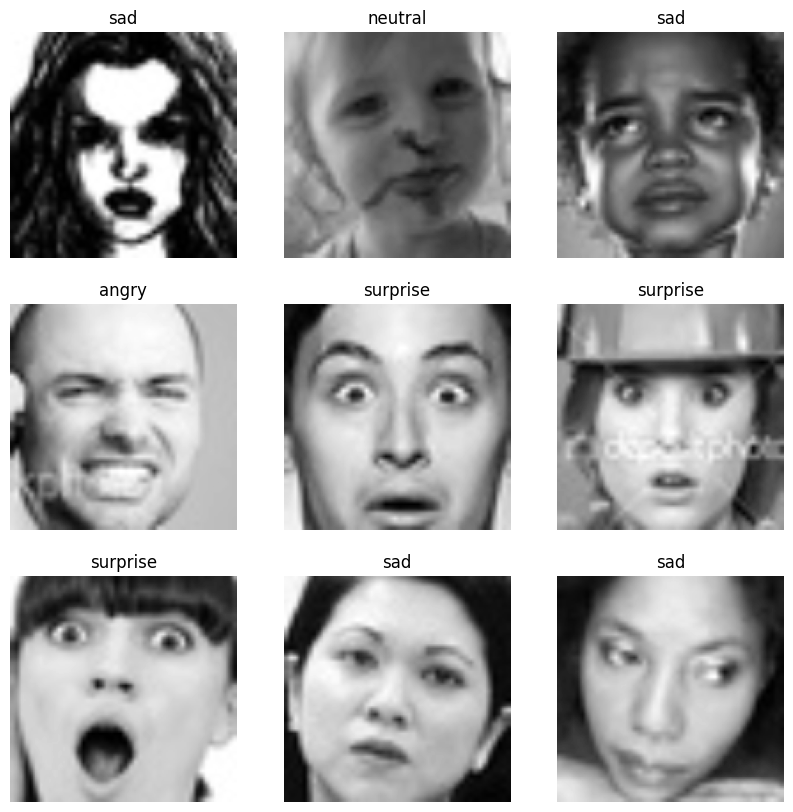

In [ ]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize = (10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow(np.squeeze(image_batch[i].numpy()), cmap = 'gray', vmin = minv, vmax = maxv)
    label = label_batch[i]
    plt.title(idx2label[label.item()])
    plt.axis('off')

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims * 4)
        self.linear2 = nn.Linear(hidden_dims*4, hidden_dims* 2)
        self.linear3 = nn.Linear(hidden_dims*2, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = MLP(input_dims = input_dims, hidden_dims = hidden_dims, output_dims = output_dims).to(device)



In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

In [ ]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim = 1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

In [ ]:
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss : {train_loss:.3f}\
    \tValidation loss : {val_loss:.3f}')


EPOCH 1:	Training loss : 1.811    	Validation loss : 1.803

EPOCH 2:	Training loss : 1.793    	Validation loss : 1.789

EPOCH 3:	Training loss : 1.780    	Validation loss : 1.778

EPOCH 4:	Training loss : 1.768    	Validation loss : 1.767

EPOCH 5:	Training loss : 1.756    	Validation loss : 1.754

EPOCH 6:	Training loss : 1.742    	Validation loss : 1.738

EPOCH 7:	Training loss : 1.724    	Validation loss : 1.719

EPOCH 8:	Training loss : 1.703    	Validation loss : 1.699

EPOCH 9:	Training loss : 1.682    	Validation loss : 1.678

EPOCH 10:	Training loss : 1.663    	Validation loss : 1.662

EPOCH 11:	Training loss : 1.648    	Validation loss : 1.650

EPOCH 12:	Training loss : 1.635    	Validation loss : 1.640

EPOCH 13:	Training loss : 1.625    	Validation loss : 1.633

EPOCH 14:	Training loss : 1.616    	Validation loss : 1.627

EPOCH 15:	Training loss : 1.607    	Validation loss : 1.620

EPOCH 16:	Training loss : 1.599    	Validation loss : 1.617

EPOCH 17:	Training loss : 1.591 

Text(0.5, 1.0, 'Validation Accuracy')

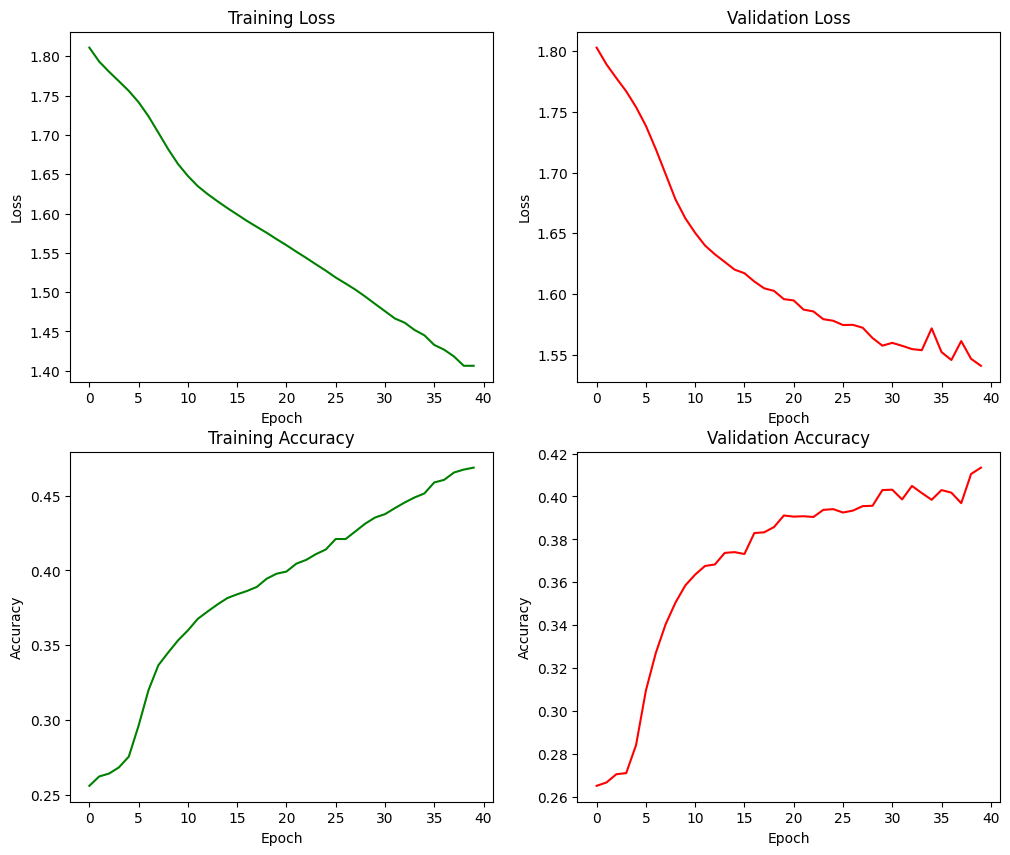

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (12,10))
ax[0, 0].plot(train_losses, color = 'green')
ax[0, 0].set(xlabel= 'Epoch', ylabel ='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color = 'red')
ax[0, 1].set(xlabel= 'Epoch', ylabel ='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color = 'green')
ax[1, 0].set(xlabel= 'Epoch', ylabel ='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color = 'red')
ax[1, 1].set(xlabel= 'Epoch', ylabel ='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

In [ ]:
#Evaluate model
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)
    print(f'Test Accuracy: {test_acc}')

Test Accuracy: 0.41571468375592086
